In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import os
import itertools
import pickle
import statistics
from sklearn.metrics import confusion_matrix
import requests, bs4
from sklearn.metrics import roc_curve, auc
pd.options.mode.chained_assignment = None  # default='warn'

I need a better way to scrape the next day's games and generate predictions before lines come out


In [27]:
db14 = pd.read_csv('WNBA14.csv')
db15 = pd.read_csv('WNBA15.csv')
db16 = pd.read_csv('WNBA16.csv')
db17 = pd.read_csv('WNBA17.csv')
db18 = pd.read_csv('WNBA18.csv')

In [28]:
db = pd.concat([db14, db15, db16, db17]).reset_index(drop = True)

/Users/ahelgeso/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [29]:
cols =  ['Result','Rolling4TSP','Rolling4TOV','Rolling4ORB','Rolling4FTR','Rolling4Poss','Opp R4Poss','Opp R4TSP','Opp R4TOV','Opp R4ORB','Opp R4FTR', 'Rolling4DEff', 'Opp R4DEff', 'Rolling4OEff','Opp R4OEff']
featureCols = ['Rolling4TSP','Rolling4TOV','Rolling4ORB','Rolling4FTR','Rolling4Poss','Opp R4Poss','Opp R4TSP','Opp R4TOV','Opp R4ORB','Opp R4FTR', 'Rolling4DEff', 'Opp R4DEff', 'Rolling4OEff','Opp R4OEff']
target = ['Result']

db = db[cols].dropna()

X = db[featureCols]
y = np.array(db[target]).flatten()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

db18['Date'] = db18['Date'].apply(str)
db18['Date'] = pd.to_datetime(db18.Date, format = "%Y%m%d")
db18 = db18.sort_values(by = ['Date']).reset_index(drop = True)
dogs2018 = db18[(db18['Odds'] > 0)].dropna().reset_index(drop = True)
Ydogs2018 = db18[(db18['Odds'] > 0)].dropna()['Result']

Below is a voting classifier which combies an Adabooster and a gradient boosting classifier

In [30]:
wins = []
losses = []
ROIs = []
profits = []

for i in range(20):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1).fit(x_train, y_train)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1).fit(x_train, y_train)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    eclf1 = VotingClassifier(estimators=[('ada', ada), ('gbc', gbc)], voting='soft')
    eclf1 = eclf1.fit(x_train, y_train)

    pred = eclf1.predict(dogs2018[featureCols])
    win = confusion_matrix(Ydogs2018, pred)[1][1]
    loss = confusion_matrix(Ydogs2018,pred)[0][1]

    odds = []
    for i, n in enumerate(pred):
        if n == 1:
            odds.append(dogs2018['Odds'][i])
    avg_odds = statistics.mean(odds)

    profit = (win * avg_odds) - (100 * loss)
    total_bet = 100 * (win + loss)
    ROI = profit/total_bet
    win = confusion_matrix(Ydogs2018, pred)[1][1]
    loss = confusion_matrix(Ydogs2018, pred)[0][1]
    
    wins.append(win)
    losses.append(loss)
    ROIs.append(ROI)
    profits.append(profit)

print("Lowest wins:", min(wins), "Lowest losses:", min(losses), 'Lowest ROI', min(ROIs), 'Lowest Profit', min(profits))
print("Avg wins:", statistics.mean(wins), "Avg losses:", statistics.mean(losses), 'Avg ROI', statistics.mean(ROIs), 'Avg Profits', statistics.mean(profits))

Lowest wins: 22 Lowest losses: 20 Lowest ROI 0.3207612456747405 Lowest Profit 1635.8823529411766
Avg wins: 26 Avg losses: 27 Avg ROI 0.6002522603711178 Avg Profits 3208.7879219185315


Voting Classifier can predict probabilities. The [:, 1] probability prediction column is probability of wins. The classifier is pretty aggressive picking dogs, so if you have a high probability difference it does a decent job of picking really heavy dogs.

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1).fit(x_train, y_train)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1).fit(x_train, y_train)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
eclf1 = VotingClassifier(estimators=[('ada', ada), ('gbc', gbc)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)

pred = eclf1.predict(dogs2018[featureCols])

earnings = []

for i, n in enumerate(pred):
    if n == 1 and dogs2018['Result'][i] == 1:
        earnings.append(dogs2018['Odds'][i])
    elif n == 1 and dogs2018['Result'][i] == 0:
        earnings.append(-100)
    else:
        earnings.append(0)

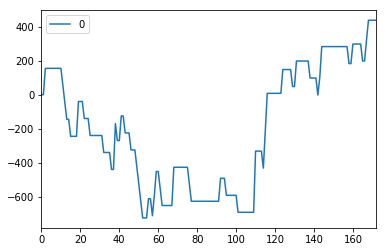

In [28]:
pd.DataFrame(earnings).cumsum().plot()

31
74
390.55238095238093


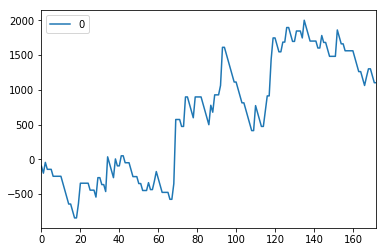

In [29]:
probs = eclf1.predict_proba(dogs2018[featureCols])[:,1]
diffs = (probs*100) - dogs2018['0']*100.0

wins = []
losses = []
profit = []
odds = []

for i, n in enumerate(dogs2018['Odds']):
    if diffs[i] > 10 and dogs2018['Result'][i] == 1:
        wins.append(1)
        profit.append(n)
        odds.append(n)
    elif diffs[i] > 10 and dogs2018['Result'][i] == 0:
        profit.append(-100)
        losses.append(1)
        odds.append(n)
    else:
        profit.append(0)
        
pd.DataFrame(profit).cumsum().plot()
print(len(wins))
print(len(losses))
print(statistics.mean(odds))

### Below is probably the best way to do this, minimizing risk of having a bad model.
#### This creates X models, sums up their predictions, and if the majority of them agree on a pick, you make that pick. Significantly reduces volatility of individual models

In [12]:
preds_avg = []
n = 100

for i in range(n):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1).fit(x_train, y_train)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=1).fit(x_train, y_train)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    eclf1 = VotingClassifier(estimators=[('ada', ada), ('gbc', gbc)], voting='soft')
    eclf1 = eclf1.fit(x_train, y_train)

    pred = eclf1.predict(dogs2018[featureCols])
    
    preds_avg.append(pred)
    
    if i%10 == 0:
        print("Model #:", i)


Model #: 0
Model #: 10
Model #: 20
Model #: 30
Model #: 40
Model #: 50
Model #: 60
Model #: 70
Model #: 80
Model #: 90


In [13]:
preds = [sum(i) for i in zip(*preds_avg)]

In [24]:
odds = []
wins = []
losses = []
profit = []
t3l = []
t2l = []
t1l = []
t3 = 0.82 * n
t2 = 0.66 * n
t1 = 0.5 * n

for i, n in enumerate(preds):
    if n >= t1 and dogs2018['Result'][i] == 1:
        wins.append(1)
        profit.append(dogs2018['Odds'][i])
        odds.append(dogs2018['Odds'][i])
        t3l.append(1)
    elif n >= t1 and dogs2018['Result'][i] == 0:
        losses.append(1)
        profit.append(-100)
        odds.append(dogs2018['Odds'][i])
        t3l.append(1)
#     elif n >= t1 and dogs2018['Result'][i] == 1:
#         wins.append(1)
#         profit.append(2 * dogs2018['Odds'][i])
#         odds.append(dogs2018['Odds'][i])
#         t2l.append(1)
#     elif n >= t1 and dogs2018['Result'][i] == 0:
#         losses.append(1)
#         profit.append(-200)
#         odds.append(dogs2018['Odds'][i])
#         t2l.append(1)
#     elif n >= t1 and dogs2018['Result'][i] == 1:
#         wins.append(1)
#         profit.append(dogs2018['Odds'][i])
#         odds.append(dogs2018['Odds'][i])
#         t1l.append(1)
#     elif n >= t1 and dogs2018['Result'][i] == 0:
#         losses.append(1)
#         profit.append(-100)
#         odds.append(dogs2018['Odds'][i])
#         t1l.append(1)
    else:
        profit.append(0)
        
avg_odds = statistics.mean(odds)
profits = sum(profit)
total_bet = 100 * (len(wins) + len(losses))
ROI = profits/total_bet
    
print('wins:', len(wins), ' losses:', len(losses), 'profit:', profits, 'total risk:', total_bet, 'avg odds:', avg_odds, 'ROI:', ROI)

wins: 31  losses: 38 profit: 2987.0 total risk: 6900 avg odds: 239.31884057971016 ROI: 0.4328985507246377


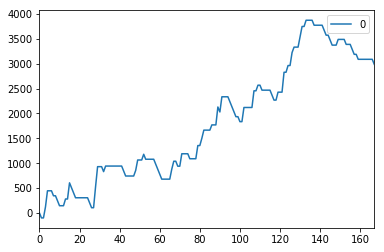

In [25]:
pd.DataFrame(profit).cumsum().plot()